# Some experiments with OpenCV

In [93]:
import cv2
import io
import numpy as np
import pandas as pd

from PIL import Image as PImage
import matplotlib.pyplot as plt
import os

import random
from sklearn.cluster import KMeans

from data_utils import balance_score, distance_score, silhouette_score
from data_utils import display_silhouette_plots


In [ ]:
# helper functions to convert between PIL and OpenCV image types

def tocv(pil):
  return np.array(pil)

def topil(cv):
  return PImage.fromarray(cv)

## Open an Image

In [ ]:
# open image from url
img = PImage.open("random_subset/plant_nadeshiko_1.jpg")
# img = PImage.open("random_subset/plant_kiri_113.jpg")

# this makes the largest edge of the image be 480
img.thumbnail((480, 480))
display(img)

## Threshold

Turn color/gray image into black and white

Doc: https://docs.opencv.org/4.x/db/d8e/tutorial_threshold.html

"In OpenCV, finding contours is like finding white object from black background. So remember, object to be found should be white and background should be black." https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html


In [ ]:
img_cv = tocv(img)
#and display pixel intensity distribution
plt.hist(img_cv.ravel(), bins=256, range=(0, 255))
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


#convert all images to grayscale if not greyscale
if len(img_cv.shape) == 3 and img_cv.shape[2] == 3:  # If the image has 3 channels (RGB)
    img_cv_grey = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
else:  # If the image is already grayscale
    img_cv_grey = img_cv
    img_cv_grey = cv2.equalizeHist(img_cv_grey) #images that are already greyscale have low contrast
    # so we equalize the intesity of each pixel



#threshold image to binary
max_value = 255
threshold_val = 128
_, img_cv_grey = cv2.threshold(img_cv_grey, threshold_val, max_value, cv2.THRESH_BINARY_INV)
#add 10 pixel border, black
img_cv_border = cv2.copyMakeBorder(img_cv_grey, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])

topil(img_cv_border)

## Erode / Dilate

Reduces / Expands white regions on the image, respectively.

By applying complementary erode/dilate operations you can get rid of gaps and concave parts of an image.

Doc: https://docs.opencv.org/4.x/db/df6/tutorial_erosion_dilatation.html

In [ ]:
# this sets up the shape and size of the erosion filter
eksize = 2
ekernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * eksize + 1, 2 * eksize + 1), (eksize, eksize))

dksize = 5
dkernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * dksize + 1, 2 * dksize + 1), (dksize, dksize))

eroded_cv = cv2.erode(img_cv_border, ekernel)
dilated_cv = cv2.dilate(img_cv_border, dkernel)

display(topil(dilated_cv))

## Extracting Outline

The function for this is called `findContours()`.

Docs: https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

In [ ]:
colors = [(220,0,0),(0,220,0),(0,0,220),(220,220,0),(0,220,220),(220,0,220)]

draw_cv = cv2.cvtColor(dilated_cv.copy(), cv2.COLOR_GRAY2RGB)

contours, hierarchy = cv2.findContours(image=dilated_cv, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

if contours:
  for idx,con in enumerate(contours):
    cv2.drawContours(draw_cv, [con], 0, colors[idx%len(colors)], 2)

display(PImage.fromarray(draw_cv))

We find the biggest contour from the dilated image, which usually is the sillhouette of the shape. This contour is a set of points which we can use as features for our model.

## Contour objects

are just lists of x,y coordinates, but for some reason opencv adds a mysterious dimension to them.

Instead of this:

```python
[
  [x0,y0], [x1,y1], [x2,y2], ...
]
```

We get this (double array around points):
```python
[
  [[x0,y0]], [[x1,y1]], [[x2,y2]], ...
]
```

We can fix it by using the `squeeze()` function which gets rid of superfluous dimensions in arrays:

In [ ]:
# if we want the first contour, this will turn it into a plain list of (x,y) coordinates
print(len(contours[0].squeeze().tolist()))
print("Contour Area:", cv2.contourArea(contours[0]))
contours[0].squeeze().tolist()

#I also want to order the points in a clockwise manner
def order_points_clockwise(pts):
    # Calculate the centroid of the points
    center = np.mean(pts, axis=0)

    # Calculate the angle of each point with respect to the centroid
    angles = np.arctan2(pts[:, 1] - center[1], pts[:, 0] - center[0])

    # Sort the points based on the angles
    sorted_indices = np.argsort(angles)
    sorted_pts = pts[sorted_indices]

    return sorted_pts

ordered_contour = order_points_clockwise(contours[0].squeeze())
ordered_contour.tolist()


In [ ]:
#alternative sorting of points:
def sort_by_angle(points):
  cx,cy = points.mean(axis=0)
  return np.array(sorted(points, key=lambda A: np.arctan2(A[1]-cy, A[0]-cx)))

sorted_contour = sort_by_angle(contours[0].squeeze())
sorted_contour.tolist()

#do they match?
np.array_equal(ordered_contour, sorted_contour)
#yes


contouring is just grabbing the outer box of the kamon, not the kamon itself. area is calculating the contour around the edge of the screen.

## Filtering

Contours: 
- with points touching the edges of the image
- larger than 70% of the image area
- smaller than 15% of the image area

are not valid.


In [ ]:
def contour_is_valid(c, h, w, m=1):
  for p in c:
    x, y = p[0]
    if x < m or x > w - m - 1 or y < m or y > h - m - 1:
      return False
  return (cv2.contourArea(c) < 0.70 * h * w) and (cv2.contourArea(c) > 0.15 * h * w)

contour_is_valid(contours[0], img.size[1] + 20 , img.size[0] + 20 )

come up with heuristic for my images - what is valid?
- contour that finds the sillhouette

## Further:
Now repeat this process for every image in the random_subset. Images that can be processed and pass the heuristic have their filename, largest contour, and area saved to a dataframe for further work.

In [ ]:
colors = [(220,0,0),(0,220,0),(0,0,220),(220,220,0),(0,220,220),(220,0,220)] # for drawing contour

def contour_from_image(path):
    # process image to get contours
    img = PImage.open(path)
    img.thumbnail((480, 480))
    img_cv = tocv(img)
    if len(img_cv.shape) == 3 and img_cv.shape[2] == 3:  # If the image has 3 channels (RGB)
        img_cv_grey = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    else:  # If the image is already grayscale
        img_cv_grey = img_cv
        #images that are already greyscale have low contrast
        # so we equalize the intesity of each pixel
        img_cv_grey = cv2.equalizeHist(img_cv_grey) 

    #threshold image to binary
    max_value = 255
    threshold_val = 128
    _, img_cv_grey = cv2.threshold(img_cv_grey, threshold_val, max_value, cv2.THRESH_BINARY_INV)
    #add 10 pixel border, black
    img_cv_border = cv2.copyMakeBorder(img_cv_grey, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    #Dilate
    dksize = 8
    dkernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * dksize + 1, 2 * dksize + 1), (dksize, dksize))
    dilated_cv = cv2.dilate(img_cv_border, dkernel)

    draw_cv = cv2.cvtColor(dilated_cv.copy(), cv2.COLOR_GRAY2RGB)

    contours, hierarchy = cv2.findContours(image=dilated_cv, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    if contours:
        for idx, con in enumerate(contours):
            cv2.drawContours(draw_cv, [con], 0, colors[idx % len(colors)], 2)

        display(PImage.fromarray(draw_cv))

        # check for valid biggest contour
        if contour_is_valid(contours[0], img.size[1] + 20, img.size[0] + 20):
            print("Valid Contour Found")
            print("Contour Area:", cv2.contourArea(contours[0]))
            #sort contour points clockwise
            sorted_contour = sort_by_angle(contours[0].squeeze())

            
            # output file name, path, contour, contour area
            return {
                "file_name": os.path.basename(path),
                "file_path": path,
                "contour": sorted_contour.tolist(),
                "contour_area": cv2.contourArea(contours[0])
            }
        else:
            print("No Valid Contour Found for",path)
    
    # Explicitly return None if no valid contour is found
    return None
        
    



In [ ]:
contour_from_image("random_subset/plant_nadeshiko_1.jpg")
contour_from_image("random_subset/plant_kiri_113.jpg")

Now, do this for all samples in the random_subset. For each sample,
 - save name of sample
 - save file path
 - save largest contour
 - save total area

In [ ]:
#go through all samples in random_subset and save contour data

success_rate = []

random_subset_contours = []
for file_path in os.listdir("random_subset"):
    #run contour extraction
    contour_data = contour_from_image(os.path.join("random_subset", file_path))
    #add to list if contour data is valid
    if contour_data is not None:
        random_subset_contours.append(contour_data)
        success_rate.append(1)
    else:
        success_rate.append(0)

    
    

In [ ]:

sum(success_rate)/len(success_rate)
#62% success rate

In [ ]:
#turn list into dataframe
random_subset_contours_df = pd.DataFrame(random_subset_contours)
random_subset_contours_df.head()

In [ ]:
#give each point in contour a column. If there are less points than max, fill with 0
max_points = max([len(c) for c in random_subset_contours_df['contour']])
max_points
# Create all x and y columns at once
x_columns = pd.DataFrame(
    {f'x_{i}': random_subset_contours_df['contour'].apply(lambda c: c[i][0] if i < len(c) else 0)
     for i in range(max_points)}
)

y_columns = pd.DataFrame(
    {f'y_{i}': random_subset_contours_df['contour'].apply(lambda c: c[i][1] if i < len(c) else 0)
     for i in range(max_points)}
)

# Concatenate the new columns to the original DataFrame
random_subset_contours_df = pd.concat([random_subset_contours_df, x_columns, y_columns], axis=1)

In [ ]:
random_subset_contours_df.head()

This leaves me with a dataframe with all succesful Kamons, their contours, contour areas, and the x-y coordinates all in their own columns. I can export this dataframe to be further processed before clustering.

In [ ]:
#export dataframe to csv
random_subset_contours_df.to_csv("random_subset_contours.csv", index=False)

For scaling later:
- make sure scaling doesn't distort points! can't just scale by column. Need to maintain shape
- find smallest and largest value across all rows and columns
    - same idea as min max but need to manually find the range and manually apply to your dataframe
    - maybe can do something with MinMax scaler of MaxAbsScaler on scikitlearn?

center the contour at (0,0)
- scale each point -1 to 1
- order points clockwise or counterclockwise? 
- ask copilot and can use the angle from the centroid of the points to sort by angle

Look at silhouette notebook for guidance (https://github.com/PSAM-5020-2025F-A/5020-utils/blob/main/datasets/prep-rev-sils.ipynb)

Train Neural Network to identify categories of Kamon?


In [ ]:
#Import

Helper Functions from Thiago (https://github.com/PSAM-5020-2025F-A/Project-OpenCV/blob/main/sorting-etc.ipynb)

In [ ]:
# flattens list of points [(x,y), (x,y), ...] into [x,y,x,y,x,y,...]
def flatten(points):
  return [v for p in points for v in p]

# turn [x,y,x,y,x,y,...] into [(x,y), (x,y), ...]
def unflatten(list_of_vals):
  # get separate lists for x and y values
  xs = list_of_vals[0::2] # go through list, starting at 0, skipping by 2
  ys = list_of_vals[1::2] # go through list, starting at 1, skipping by 2

  # put the pairs into list of pairs
  return [[x,y] for x,y in zip(xs,ys)]

In [ ]:
# find closest point to p in list of points ps
def closest_point(p, ps):

  # euclidean dist to p (without sqrt)
  def dist_to_p(op):
    return (p[0] - op[0]) ** 2 + (p[1] - op[1]) ** 2

  # sort by distance to p
  sorted_by_dist_to_p = sorted(ps, key=dist_to_p)

  # first one is the closest
  return sorted_by_dist_to_p[0]

In [ ]:
#Random input data

# Creating 4 lists of random points as stand-in for contours.
# Each list has a different number of values between -2 and 12.

random_lists = []
for lcnt in range(4):
  list_len = random.randrange(16, 24, 2)
  list_min = random.uniform(-2, 2)
  list_max = random.uniform(8, 12)
  random_lists.append([random.uniform(list_min, list_max) for cnt in range(list_len)])

# list lengths
[len(l) for l in random_lists]

In [ ]:
random_lists
unflatten(random_lists)

In [ ]:
min_len = min([len(l) for l in random_lists])
min_points = min_len // 2

random_lists_same_len = []

# for each list/contour
for l in random_lists:
  
  points = unflatten(l)

  # cluster into min_points clusters
  km = KMeans(n_clusters=min_points)

  # x and y are columns and each point is a sample
  clusters = km.fit_transform(points)

  # if your points are dense, you can probably use the cluster centers as the new points
  random_lists_same_len.append(km.cluster_centers_.tolist())

  # the more correct way to do this is to look in the original list for the closest point to each cluster center
  random_lists_same_len.append([
    closest_point(p, points) for p in km.cluster_centers_
  ])

[len(l) for l in random_lists_same_len]

In [ ]:
# create names for columns
col_names = flatten([[f"x{i}", f"y{i}"] for i in range(min_points)])

# flatten each list of points
df_vals = [flatten(points) for points in random_lists_same_len]

In [ ]:
# DataFrame it
df = pd.DataFrame(df_vals, columns=col_names)

# repeated rows due to appending random_lists_same_len twice in each iteration in the cell above
df

In [ ]:
# given a row, center it's data points on 0,0
def center_row(row):
  vmin,vmax = row.min(), row.max()
  vrange = (vmax - vmin)

  # scale row to [0,1]
  row_01 = (row - vmin) / vrange

  # scale row to [-vrange/2, vrange/2]
  row_c = vrange * (row_01 - 0.5)
  return row_c

In [ ]:
# apply the function to every row
centered_df = df.apply(center_row, axis=1)
centered_df

In [ ]:
def sort_by_angle(points):

  def angle(xy):
    x,y=xy
    return np.atan2(y, x) + np.pi # adding pi so angle is between [0,2pi] and not [-pi,pi]

  return sorted(points, key=angle)

In [ ]:
# TODO: got through each row,
#       turn vals into points (unflatten),
#       sort points by angle,
#       turn points into vals (flatten)

list_1_unflat = unflatten(centered_df.iloc[0].tolist())
sort_by_angle(list_1_unflat)
list_1_flat = flatten(sort_by_angle(list_1_unflat))
list_1_flat

Let's try this on my own dataset.

In [ ]:
#import random_subset_contours.csv
contours_df = pd.read_csv("random_subset_contours.csv")
contours_df.head()

In [ ]:
#extract contours for each image from contour column. Add these to a list.
contour_list = []
for idx, row in contours_df.iterrows():
    contour = eval(row['contour'])  # Convert string representation of list back to list
    contour_list.append(contour)


In [ ]:
#KMeans to make list of contours same length
min_length = min([len(c) for c in contour_list])
min_points = min_length // 2

contour_list_samlen = []
for c in contour_list:
  
    points = c

    #Cluster with KMeans
    km = KMeans(n_clusters=min_points)

    # x and y are columns and each point is a sample
    clusters = km.fit_transform(points)

    #look in original list for closest point to each cluster center
    contour_list_samlen.append([
      closest_point(p, points) for p in km.cluster_centers_
    ])


In [ ]:
#create names for columns
col_names = flatten([[f"x{i}", f"y{i}"] for i in range(min_points)])

#flatten each list of points
df_vals = [flatten(points) for points in contour_list_samlen]

#dataframe
contours_samelen_df = pd.DataFrame(df_vals, columns=col_names)
contours_samelen_df

In [ ]:
#Center

#given a row, center data points on 0,0
centered_df = contours_samelen_df.apply(center_row, axis=1)
centered_df

In [101]:
#arrange points by angle (which was done in a previous step, but maybe not for this data, which is taken from the contour column)

# TODO: got through each row,
#       turn vals into points (unflatten),
#       sort points by angle,
#       turn points into vals (flatten)

centered_sorted_df = centered_df.copy()

for idx, row in centered_sorted_df.iterrows():
    points = unflatten(row.tolist())
    sorted_points = sort_by_angle(points)
    flattened_sorted_points = flatten(sorted_points)
    centered_sorted_df.iloc[idx] = flattened_sorted_points



In [103]:
test_row = centered_sorted_df.iloc[0]
test_points = unflatten(test_row.tolist())
test_sorted_points = sort_by_angle(test_points)

In [105]:
type(test_points)

list

In [ ]:
centered_sorted_df

In [ ]:
#add back to dataframe with file names
final_df = pd.concat([contours_df[['file_name', 'file_path']], centered_sorted_df], axis=1)
final_df

In [ ]:
#export to csv

final_df.to_csv("random_subset_contours_processed.csv", index=False)

# Clustering with KMeans

Cluster using all points x0 to x122, for each object
- this is more than 2 or 3 dimensions, so may be trickier to visualize!


In [ ]:
#features are the x and y coordinates of each point in the contour, so need to drop first two columns
feature_df = final_df.drop(columns=['file_name', 'file_path'])
feature_df
feature_df.cov()

In [ ]:
#let's try 6 clusters and see what we get

n_cluster = 6
km_model = KMeans(n_clusters=n_cluster, random_state=1010)

#run model
km_pred = km_model.fit_predict(feature_df)


In [92]:
#Score
print("KMeans objective score:", km_model.score(feature_df))

print("KMeans distance score:", distance_score(feature_df, km_pred))
print("KMeans silhouette score:", silhouette_score(feature_df, km_pred))
print("KMeans balance score:", balance_score(km_pred))

KMeans objective score: -3929266.0179692865
KMeans distance score: 114.07140790002939
KMeans silhouette score: 0.24317746295209164
KMeans balance score: 0.6486646884272997


/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


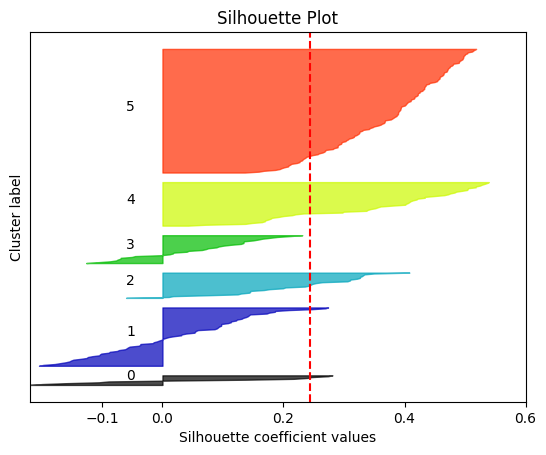

In [94]:
display_silhouette_plots(feature_df, km_pred)


Try several clusters:

/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


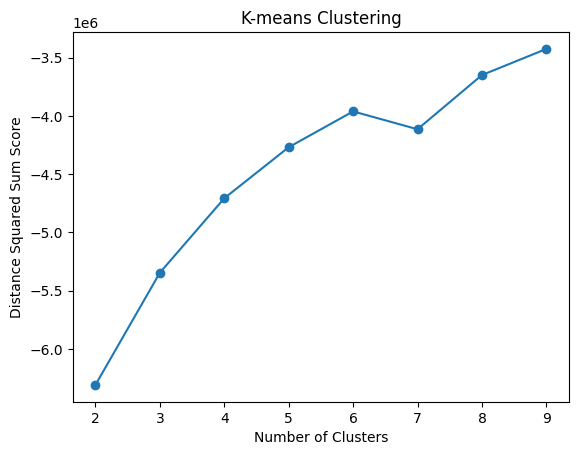

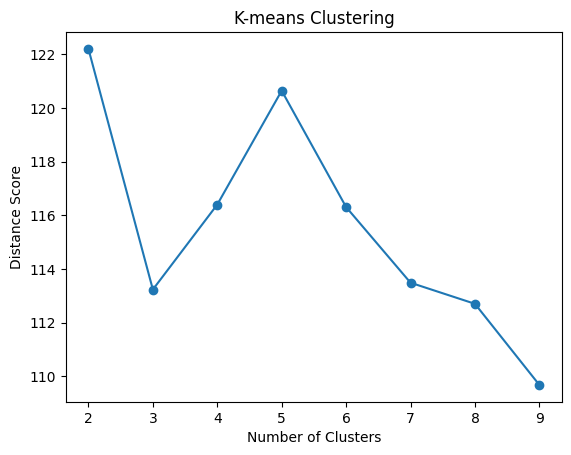

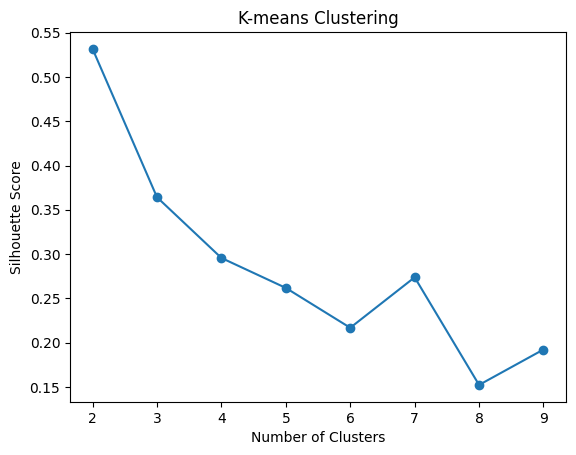

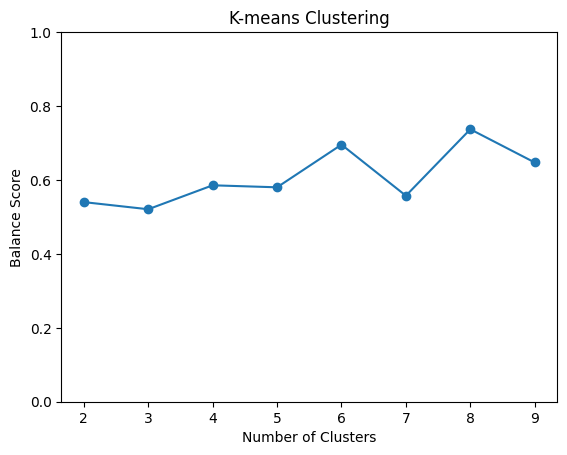

In [95]:
# try 2 - 10 clusters for K-Means Clustering
num_clusters = list(range(2,10))

# collect distance, silhouette and balance scores
score_scores = []
distance_scores = []
silhouette_scores = []
balance_scores = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = KMeans(n_clusters=n)
  pred = mm.fit_predict(feature_df)
  score_scores.append(mm.score(feature_df))
  distance_scores.append(distance_score(feature_df, pred))
  silhouette_scores.append(silhouette_score(feature_df, pred))
  balance_scores.append(balance_score(pred))

# plot scores as function of number of clusters
plt.plot(num_clusters, score_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Squared Sum Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, distance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-means Clustering")
# plt.ylim([-1, 1])
plt.show()

plt.plot(num_clusters, balance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Score")
plt.title("K-means Clustering")
plt.ylim([0, 1])
plt.show()

Balance Score improves with more clusters

Distance score happiest at 2 or 5 clusters

# How do we visualize this?
While we can't directly visualize the clusters in 2d or 3d space (as we're using >200 features for each), each Kamon should be grouped into a specific cluster. We can look at each cluster and see if there are visual patterns the KMeans algorithm is picking up on.

In [99]:
#For n=5 clusters, which Kamon belong to which cluster?

#run the model again
n_cluster = 5
km_model = KMeans(n_clusters=n_cluster, random_state=1010)

#run model
km_pred = km_model.fit_predict(feature_df)

km_cluster_df = final_df.copy()
km_cluster_df['cluster'] = km_pred
km_cluster_df

/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nichosmolnar/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


,file_name,file_path,x0,y0,x1,y1,x2,y2,x3,y3,...,y121,x122,y122,x123,y123,x124,y124,x125,y125,cluster
0,geometry_turtle_shell_49.jpg,random_subset/geometry_turtle_shell_49.jpg,-52.5,-1.5,-48.5,-3.5,-45.5,-5.5,-41.5,-7.5,...,16.5,-62.5,12.5,-62.5,8.5,-58.5,5.5,-54.5,1.5,0
1,object_anchor_10.jpg,random_subset/object_anchor_10.jpg,-62.5,-3.5,-62.5,-9.5,-60.5,-16.5,-56.5,-21.5,...,6.5,-54.5,11.5,-27.5,4.5,-58.5,7.5,-61.5,2.5,0
2,object_mari_scissors_3.jpg,random_subset/object_mari_scissors_3.jpg,-51.5,-4.5,-52.5,-8.5,-53.5,-12.5,-55.5,-16.5,...,18.5,-54.5,14.5,-52.5,10.5,-51.5,5.5,-50.5,0.5,3
3,plant_tachibana_5.jpg,random_subset/plant_tachibana_5.jpg,-51.5,-2.5,-54.5,-5.5,-56.5,-8.5,-57.5,-10.5,...,8.5,-41.5,7.5,-43.5,5.5,-45.5,3.5,-48.5,0.5,3
4,object_kamashiki_4.jpg,random_subset/object_kamashiki_4.jpg,-60.5,-0.5,-62.5,-3.5,-64.5,-6.5,-66.5,-10.5,...,19.5,-67.5,15.5,-66.5,11.5,-65.5,7.5,-62.5,3.5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,plant_tachibana_12.jpg,random_subset/plant_tachibana_12.jpg,-55.5,-0.5,-57.5,-2.5,-58.5,-4.5,-60.5,-7.5,...,14.5,-61.5,12.5,-60.5,8.5,-58.5,4.5,-57.5,1.5,1
333,plant_bamboo_11.jpg,random_subset/plant_bamboo_11.jpg,-62.0,-3.0,-62.0,-6.0,-61.0,-9.0,-61.0,-12.0,...,13.0,-61.0,10.0,-61.0,6.0,-62.0,3.0,-62.0,0.0,1
334,geometry_meyui_58.jpg,random_subset/geometry_meyui_58.jpg,-42.0,-1.0,-44.0,-2.0,-47.0,-4.0,-49.0,-6.0,...,6.0,-33.0,5.0,-35.0,4.0,-37.0,2.0,-40.0,0.0,2
335,object_arrowhead_yajiri_0.jpg,random_subset/object_arrowhead_yajiri_0.jpg,-55.5,-0.5,-51.5,-2.5,-49.5,-5.5,-52.5,-9.5,...,11.5,-66.5,9.5,-62.5,7.5,-59.5,5.5,-58.5,1.5,3


Cluster 0


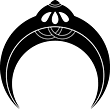

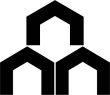

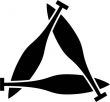

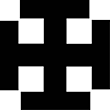

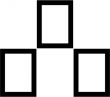

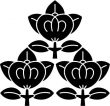

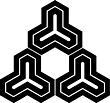

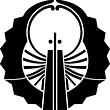

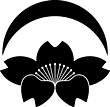

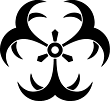

Cluster 1


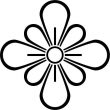

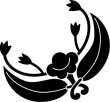

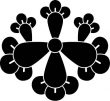

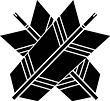

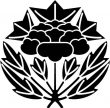

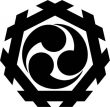

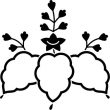

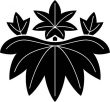

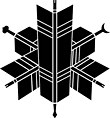

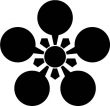

Cluster 2


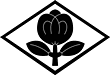

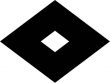

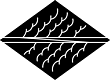

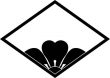

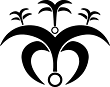

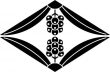

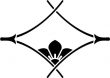

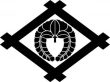

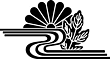

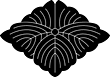

Cluster 3


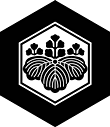

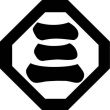

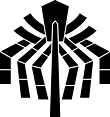

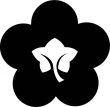

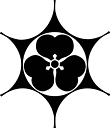

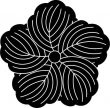

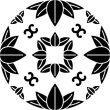

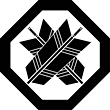

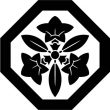

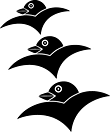

Cluster 4


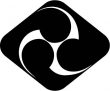

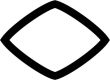

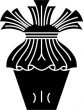

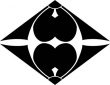

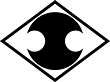

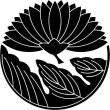

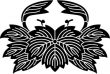

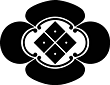

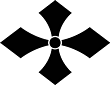

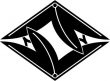

In [100]:
#show 10 images from each cluster
for c in range(n_cluster):
    print("Cluster", c)
    cluster_samples = km_cluster_df[km_cluster_df['cluster'] == c]
    sample_paths = cluster_samples['file_path'].tolist()
    #randomly select 10 samples
    sample_paths_10 = random.sample(sample_paths, min(10, len(sample_paths)))
    #display images
    for path in sample_paths_10:
        img = PImage.open(path)
        img.thumbnail((200, 200))
        display(img)